# Bayesian Logistic Regression

The Goal of this notebook is to recap Bayesian Machine Learning for Allianz Partners Internship and conclude pros and cons Bayesian Logistic Regression using PyMC3 and TensorFlow Probability


07/07/2020



# 1. Table of Context
[I. Bayesian Basic Concept](#concept)

[II. PyMC3 vs. TensorFlow Probability](#vs)

[III. Bayesian Logistic with PyMC3](#pymc3)
- [1. HamiltionMC](#hmc)
- [2. Laplace Approximation](#la)
    
[IV. Tensorflow Probability](#tf)
    


## <a name = concept></a>Bayesian Basic Concept
### Why use Bayesian?

Allianz has limited flight transaction data. Bayesian Machine Learning works well on small dataset and allows us to update parameters when having new data as well as encode our prior knowledge. By combining Bayes in the recommendation system, it can provide clients a more optimized personal ranked list of plans instead of predicting whether a plan is selected or not.

By fitting samples to prior knowledge, we can get a posterior distribution of parameters which describes the data distribution. However, since the denominator of calculating posterior probability is intractable, we use following method to find the approximate solutions to the posterior.

**How to approximate posterior?**
1.	Sampling method - MCMC
    - Metropolis-Hasting
    - Gibbs Sampling
    
2.	Laplace Inference
3.	Variation Inference


### MCMC

MCMC provides us with ways to sample any probability distribution. This is mostly needed when we want to sample from a posterior distribution
- Markov Property: Next state only depends on current state
- Markov Chain: We will reach the stationary distribution no matter which initial state it stands after many iterations (converge)
- Monte Carlo: Random sampling

*Advantage*
1. Guaranteed to find a globally optimal solution given enough time
2.	Easy to implement and reliable

*Disadvantage*
1. Slow. It is difficult to tell how close they are to a good solution given the finite amount of time that they have in practice
2. In order to quickly reach to a good solution, MCMC methods require choosing an appropriate sampling technique!

*Algorithm:*
1. Metropolis-Hasting
   - Accept/Reject algorithm
   - Need to choose proposal distribution (Require proposal distribution be symmetric)
   
2. Gibbs Sampling
   - Faster, since Gibbs sampling accept all proposals

Both Metropolis Hasting and Gibbs Sampling are slow for correlated parameters


### Laplace Approximation

Aim to approximate the posterior with a normal distribution centered at the MAP estimate. Mode = MAP, variance = 1/A where A is a Hessian matrix and A must be positive definite

*Advantage*
- Faster than sampling method

*Disadvantage*
- Normal distribution can't approximate everything, for example discrete distribution

### Variance Inference
Variance Inference is a more advanced method, the difference between sampling and variational techniques are:
- Unlike sampling-based methods, variational approaches will almost never find the globally optimal solution
- Always know if they have converged
- variational inference methods often scale better and are more amenable to techniques like stochastic gradient optimization, parallelization over multiple processors and acceleration using GPUs


## <a name = vs></a> PyMC3 vs. Tensorflow Probability
For both method, I used following parameters to train the model. 
1. mean = 0
2. std = 1000
3. sampling method = HamiltonianMC
4. Number of samples = 10000
5. Number of burn-in = 2000

Result
From the result, PyMC3 train the model a lot faster than TensorFlow, and the code is a lot simple than TensorFlow as well as more resource to refer. However, TensorFlow Probability offers flexible functions that is easy to customize optimal pipeline. Laplace approximation is faster than MCMC, however, it is hard to check the convergence and hence hard to check the correctness. The std of Laplace approx is different from HamiltonianMC.

Method | alpha mean | alpha std | beta mean | beta std | Traing Wall time |
--- | --- | --- | --- | --- | --- |
PyMC3 | -18.962 | 8.82 | 0.291 | 0.129 | 21.5 s|
TensorFlow Probability | -15.715 | 7.284 | 0.25 | 0.11 |55 min 48 s|
PyMC3(Laplace approx) | -15.042 | 0.067 | 0.232 | 0.008 | 3.96s |


## <a name = pymc3></a>Bayesian Logistic Regression with PyMC3
**Dataset:**
The data was the record of Temperature and Damage Incident occurance from twenty-fifth flight of the U.S. space shuttle program. This dataset only contains 1 features, Temperature. We want to know "At temperature $t$, what is the probability of a damage incident?"

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split

import wget

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from IPython.core.pylabtools import figsize

In [2]:
# Download Dataset
url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
filename = wget.download(url)

df = pd.read_csv('https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv')
df.head(2)

,Date,Temperature,Damage Incident
0,04/12/1981,66,0
1,11/12/1981,70,1


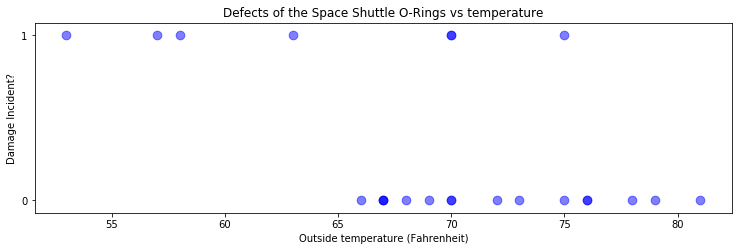

In [46]:
plt.figure(figsize(12.5, 3.5))
np.set_printoptions(precision=3, suppress=True)
challenger_data_ = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data_ = challenger_data_[~np.isnan(challenger_data_[:, 1])]

plt.scatter(challenger_data_[:, 0], challenger_data_[:, 1], s=75, color="b",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("Damage Incident?")
plt.xlabel("Outside temperature (Fahrenheit)")
plt.title("Defects of the Space Shuttle O-Rings vs temperature");

### Bayesian Logistic Regression - Pymc3
#### Logistic Regression
<img src = 'https://www.saedsayad.com/images/LogReg_1.png' width = '500/'>

In [63]:
import pymc3 as pm

temperature = challenger_data_[:, 0]
D = challenger_data_[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sd = 1000.)
    alpha = pm.Normal("alpha", mu=0., sd = 1000.)
    # deterministic (expected value of outcome)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))


#### <a name = hmc></a> MCMC - HamiltonMC

In [64]:
%%time
with model:
    observed = pm.Bernoulli("Y_obs", p, observed=D)
    
    
    # Sampling using Metropolis
    start = pm.find_MAP()
    step = pm.HamiltonianMC()
    trace = pm.sample(10000, step=step, start=start)
    burned_trace = trace[2000::2]
    

ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


CPU times: user 8.21 s, sys: 557 ms, total: 8.77 s
Wall time: 21.5 s


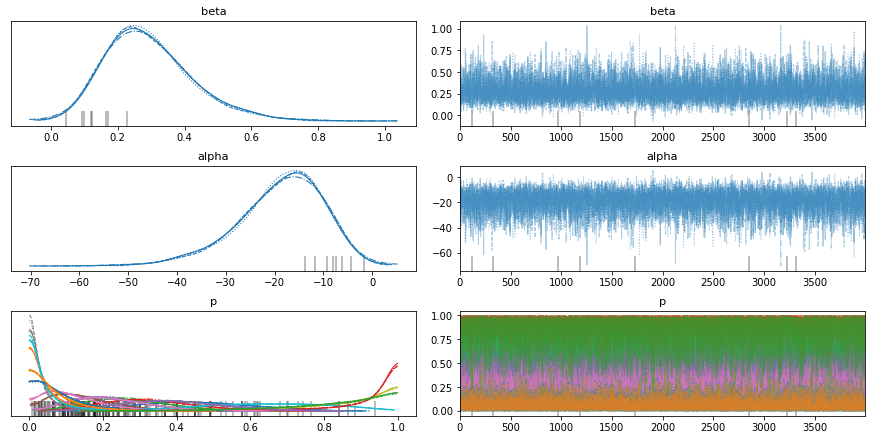

In [65]:
pm.traceplot(burned_trace); # converge

In [66]:
pd.DataFrame(pm.summary(burned_trace)).loc[['beta', 'alpha'], ['mean', 'sd']]

,mean,sd
beta,0.291,0.129
alpha,-18.962,8.820


#### <a name = la></a> Laplace Approximation
It is faster than MCMC, however, the std calculated by Laplace Approximation is a lot different from MCMC

In [58]:
import pymc3 as pm

temperature = challenger_data_[:, 0]
D = challenger_data_[:, 1]  # defect or not?

#notice the`value` here. We explain why below.
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0., sd = 1000.)
    alpha = pm.Normal("alpha", mu=0., sd = 1000.)
    p = pm.Deterministic("p", 1.0/(1. + tt.exp(beta*temperature + alpha)))

In [59]:
%%time
with model:
    observed = pm.Bernoulli("Y_obs", p, observed=D)
    
    # Sampling using Laplace Approximation
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q))**0.5)[0]
print(f"beta, alpha \nmean: {[mean_q[i] for i in ['beta', 'alpha']]},\nstd = {std_q}")


beta, alpha 
mean: [array(0.232), array(-15.042)],
std = [0.008 0.067]
CPU times: user 3.61 s, sys: 123 ms, total: 3.73 s
Wall time: 3.96 s


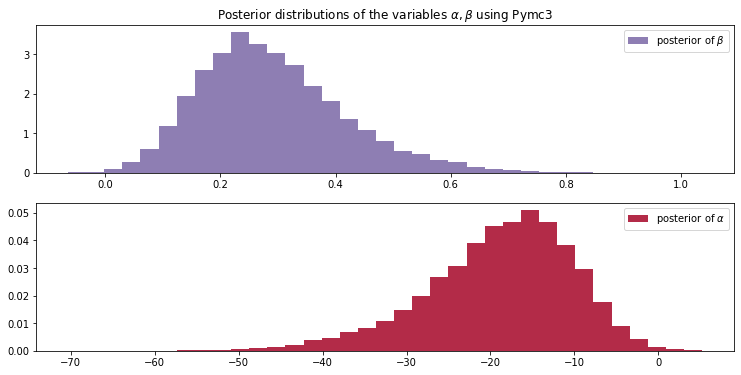

In [67]:
# Draw posterior distribution based on MCMC
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$ using Pymc3")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="#7A68A6", normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="#A60628", normed=True)
plt.legend();

In [78]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))
t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

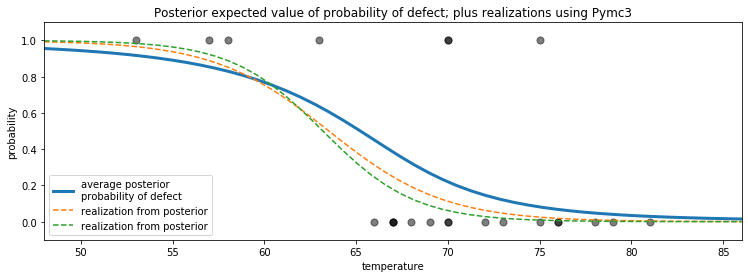

In [79]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t, p_t[0, :], ls="--", label="realization from posterior")
plt.plot(t, p_t[-2, :], ls="--", label="realization from posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations using Pymc3")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature");

## <a name = tf></a>Bayesian Logistic Regerssion - Tensorflow

In [34]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

In [7]:
temperature_ = challenger_data_[:, 0]
temperature = tf.convert_to_tensor(temperature_, dtype=tf.float32)
D_ = challenger_data_[:, 1]                # defect or not?
D = tf.convert_to_tensor(D_, dtype=tf.float32)

beta = tfd.Normal(name="beta", loc=0.3, scale=1000.).sample()
alpha = tfd.Normal(name="alpha", loc=-15., scale=1000.).sample()
p_deterministic = tfd.Deterministic(name="p", loc=1.0/(1. + tf.exp(beta * temperature_ + alpha))).sample()

[
    prior_alpha_,
    prior_beta_,
    p_deterministic_,
    D_,
] = evaluate([
    alpha,
    beta,
    p_deterministic,
    D,
])

In [8]:
def challenger_joint_log_prob(D, temperature_, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      D: The Data from the challenger disaster representing presence or 
         absence of defect
      temperature_: The Data from the challenger disaster, specifically the temperature on 
         the days of the observation of the presence or absence of a defect
      alpha: one of the inputs of the HMC
      beta: one of the inputs of the HMC
    Returns: 
      Joint log probability creates a joint log probability function which takes an input of samples and
      returns the log probability of the given sample in the model.
    """
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)

    # make this into a logit
    logistic_p = 1.0/(1. + tf.exp(beta * tf.compat.v1.to_float(temperature_) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )

In [10]:
%%time
number_of_steps = 10000 #@param {type:"slider", min:2500, max:120000, step:100}
burnin = 2000 #@param {type:"slider", min:2000, max:100000, step:100}

# Set the chain's start state.
initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
    0. * tf.ones([], dtype=tf.float32, name="init_beta")
]

# Since HMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
# Alpha is 100x of beta approximately, so apply Affine scalar bijector
# to multiply the unconstrained alpha by 100 to get back to 
# the Challenger problem space
unconstraining_bijectors = [
    tfp.bijectors.AffineScalar(100.),
    tfp.bijectors.Identity()
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: challenger_joint_log_prob(D, temperature_, *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.01, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=40, #to improve convergence
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
            num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = tfp.mcmc.sample_chain(
    num_results = number_of_steps,
    num_burnin_steps = burnin,
    current_state=initial_chain_state,
    kernel=hmc)

## Initialize any created variables for preconditions
init_g = tf.compat.v1.global_variables_initializer()

CPU times: user 55min 38s, sys: 2.24 s, total: 55min 40s
Wall time: 55min 48s


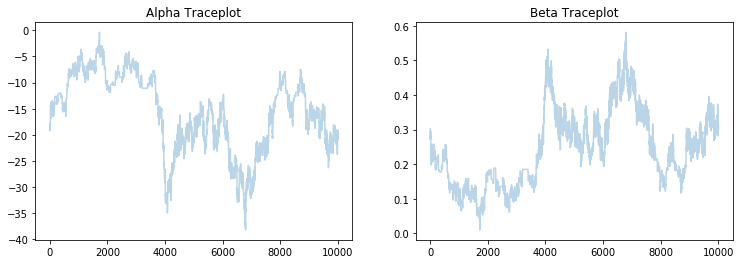

In [30]:
# trace plot
plt.subplot(121)
plt.plot(posterior_alpha.numpy(),alpha=0.3)
plt.title('Alpha Traceplot')
plt.subplot(122)
plt.plot(posterior_beta.numpy(),alpha=0.3);
plt.title('Beta Traceplot');

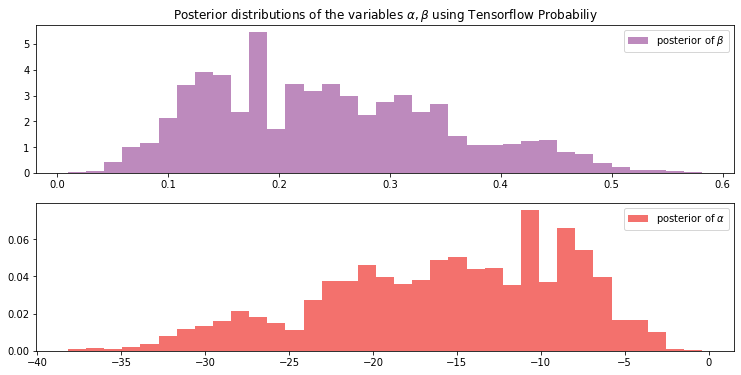

In [41]:
plt.figure(figsize(12.5, 6))

#histogram of the samples:
plt.subplot(211)
plt.title(r"Posterior distributions of the variables $\alpha, \beta$ using Tensorflow Probabiliy")
plt.hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color=TFColor[6], density=True)
plt.legend()

plt.subplot(212)
plt.hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color=TFColor[0], density=True)
plt.legend();


In [75]:
alpha_samples_1d_ = posterior_alpha_[:, None]  # best to make them 1d
beta_samples_1d_ = posterior_beta_[:, None]

beta_mean = tf.reduce_mean(beta_samples_1d_.T[0])
alpha_mean = tf.reduce_mean(alpha_samples_1d_.T[0])
[ beta_mean_, alpha_mean_ ] = evaluate([ beta_mean, alpha_mean ])


print("beta mean:", beta_mean_)
print('beta std:' , posterior_beta_.std())
print("alpha mean:", alpha_mean_)
print('alpha std:' , posterior_alpha_.std())
def logistic(x, beta, alpha=0):
    """
    Logistic function with alpha and beta.
        
    Args:
      x: independent variable
      beta: beta term 
      alpha: alpha term
    Returns: 
      Logistic function
    """
    return 1.0 / (1.0 + tf.exp((beta * x) + alpha))

t_ = np.linspace(temperature_.min() - 5, temperature_.max() + 5, 2500)[:, None]
p_t = logistic(t_.T, beta_samples_1d_, alpha_samples_1d_)
mean_prob_t = logistic(t_.T, beta_mean_, alpha_mean_)
[ 
    p_t_, mean_prob_t_
] = evaluate([ 
    p_t, mean_prob_t
])

beta mean: 0.24297327
beta std: 0.107076116
alpha mean: -15.715017
alpha std: 7.2836585


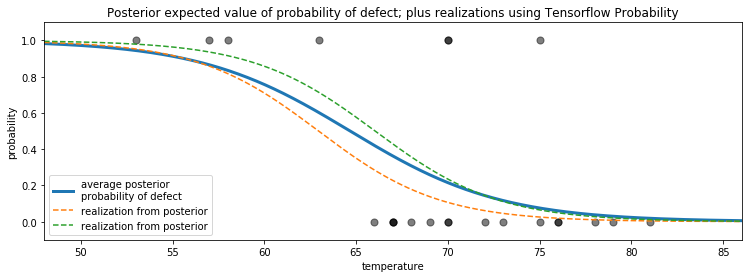

In [76]:
plt.figure(figsize(12.5, 4))

plt.plot(t_, mean_prob_t_.T, lw=3, label="average posterior \nprobability \
of defect")
plt.plot(t_, p_t_.T[:, 0], ls="--", label="realization from posterior")
plt.plot(t_, p_t_.T[:, -8], ls="--", label="realization from posterior")
plt.scatter(temperature_, D_, color="k", s=50, alpha=0.5)
plt.title("Posterior expected value of probability of defect; \
plus realizations using Tensorflow Probability")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t_.min(), t_.max())
plt.ylabel("probability")
plt.xlabel("temperature");